<a href="https://colab.research.google.com/github/HanzhouLiu/Deep-Learning-with-Python-Exercises/blob/main/1dCNN%26RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

data_dir = '/content/drive/MyDrive/636/homework'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 45s 88ms/step - loss: 0.4562 - val_loss: 0.4482
Epoch 2/20
500/500 [==============================] - 43s 87ms/step - loss: 0.3710 - val_loss: 0.4713
Epoch 3/20
500/500 [==============================] - 43s 87ms/step - loss: 0.3442 - val_loss: 0.4443
Epoch 4/20
500/500 [==============================] - 44s 87ms/step - loss: 0.3251 - val_loss: 0.4581
Epoch 5/20
500/500 [==============================] - 44s 87ms/step - loss: 0.3088 - val_loss: 0.4523
Epoch 6/20
500/500 [==============================] - 43s 86ms/step - loss: 0.3013 - val_loss: 0.4321
Epoch 7/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2927 - val_loss: 0.4610
Epoch 8/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2860 - val_loss: 0.4533
Epoch 9/20
500/500 [==============================] - 44s 87ms/step - loss: 0.2772 - val_loss: 0.4547
Epoch 10/20
500/500 [==============================] - 44s 87ms/step - loss: 0.273

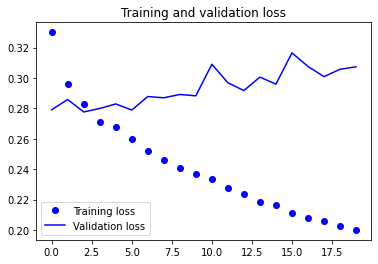

In [34]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [ ]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 91s 177ms/step - loss: 0.3636 - val_loss: 0.2791
Epoch 2/20
500/500 [==============================] - 88s 175ms/step - loss: 0.2998 - val_loss: 0.2858
Epoch 3/20
500/500 [==============================] - 88s 176ms/step - loss: 0.2856 - val_loss: 0.2776
Epoch 4/20
500/500 [==============================] - 87s 175ms/step - loss: 0.2736 - val_loss: 0.2799
Epoch 5/20
500/500 [==============================] - 88s 176ms/step - loss: 0.2706 - val_loss: 0.2829
Epoch 6/20
500/500 [==============================] - 88s 176ms/step - loss: 0.2612 - val_loss: 0.2789
Epoch 7/20
500/500 [==============================] - 88s 177ms/step - loss: 0.2537 - val_loss: 0.2878
Epoch 8/20
500/500 [==============================] - 89s 177ms/step - loss: 0.2490 - val_loss: 0.2869
Epoch 9/20
500/500 [==============================] - 88s 176ms/step - loss: 0.2421 - val_loss: 0.2891
Epoch 10/20
500/500 [==============================] - 88s 176ms/step - loss: 0.2389

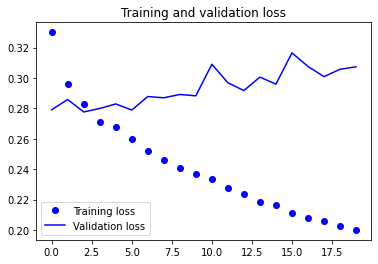

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/636/homework/1dCNN&RNN.h5")

In [32]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/636/homework/1dCNN.h5')

In [39]:
#! mkdir /tmp/my_log_dir
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir='/tmp/my_log_dir',
        histogram_freq=1,
        embeddings_freq=1,
    )
]
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks=callbacks
                              )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 93s 180ms/step - loss: 0.3584 - val_loss: 0.2820
Epoch 2/20
500/500 [==============================] - 90s 179ms/step - loss: 0.3000 - val_loss: 0.2877
Epoch 3/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2871 - val_loss: 0.2886
Epoch 4/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2752 - val_loss: 0.2859
Epoch 5/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2702 - val_loss: 0.2830
Epoch 6/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2609 - val_loss: 0.2886
Epoch 7/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2574 - val_loss: 0.2848
Epoch 8/20
500/500 [==============================] - 89s 179ms/step - loss: 0.2501 - val_loss: 0.2892
Epoch 9/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2466 - val_loss: 0.3030
Epoch 10/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2404

In [41]:
! tensorboard --logdir=/tmp/my_log_dir

2021-03-16 20:58:30.072532: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


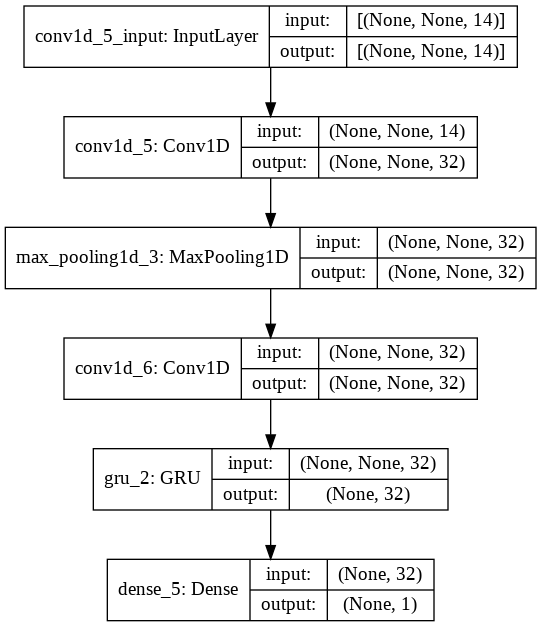

In [42]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')